# 🔰PyTorchでニューラルネットワーク基礎 #05 【画像分類・プーリング層】
* Qiitaの記事と連動しています
* 利用データ：aiueo.npz
* 独立行政法人産業技術総合研究所のETL文字データベースを利用させていただきました。「あ・い・う・え・お」の５種類の画像を抽出しMNISTと対応させるべく28x28サイズに縮小したものを利用しています

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
#デバイスの選択
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using Device Name:", device)

Using Device Name: cuda:0


In [3]:
# 精度を計算する関数
def accuracy(y, t):
    _, argmax_list = torch.max(y, dim=1)
    accuracy = sum(argmax_list == t).item()/len(t)
    return accuracy

In [4]:
data = np.load("./data/aiueo.npz")
x = data["x"]
t = data["t"]

# torchテンソルに変換
x = torch.FloatTensor(x).to(device)
t = torch.LongTensor(t).to(device)

x, x_test, t, t_test = train_test_split(x,t, test_size=0.1, random_state=55)

In [5]:
x.shape, x_test.shape, t.shape

(torch.Size([712, 1, 28, 28]), torch.Size([80, 1, 28, 28]), torch.Size([712]))

## 確認ポイント
1. カーネルサイズと出力後の形状
2. out_channelsの効果
3. flatten
4. Linearのin_featuresの計算方法
5. 活性化関数の引数
   * nn.LeakyReLU()の場合は、\_\_init__ 内でオプションを指定
   * F.leaky_relu()の場合は、forward()で使うときに、 F.leaky_relu(h, negative_slope=0.01)と使用時にオプションを記入
     

In [103]:
14-5+1

10

In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=5 ,kernel_size=5)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU導入
        self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)

        self.flat = nn.Flatten()
        self.fc1 =  nn.Linear(in_features=5*12*12, out_features=100)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=5)
        
    def forward(self, x):
        h1 = self.cnn1(x)
        h = self.act1(h1)
        h2 = self.pool1(h)
        h = self.flat(h2)
        h = self.fc1(h)
        h = self.act2(h)
        y = self.fc2(h)
        return y, h1, h2

In [7]:
model = DNN()
model.to(device)

DNN(
  (cnn1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (act1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=720, out_features=100, bias=True)
  (act2): ReLU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [8]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters())

In [9]:
# 機械学習
LOOP = 150
for epoch in range(LOOP):
    optimizer.zero_grad()
    y,h1,h2 = model(x)
    loss = criterion(y, t)
    acc  = accuracy(y,t)
    loss.backward()
    optimizer.step()
    if (epoch+1)%10 == 0:
        print(f"{epoch}: loss: {loss.item()}, acc: {acc}")  # バッチ全体での損失や精度

9: loss: 1.2489912509918213, acc: 0.8623595505617978
19: loss: 0.7806177735328674, acc: 0.8735955056179775
29: loss: 0.49601149559020996, acc: 0.8904494382022472
39: loss: 0.38644516468048096, acc: 0.9087078651685393
49: loss: 0.3217359483242035, acc: 0.9269662921348315
59: loss: 0.27350902557373047, acc: 0.9396067415730337
69: loss: 0.2350500524044037, acc: 0.9452247191011236
79: loss: 0.20280060172080994, acc: 0.9564606741573034
89: loss: 0.17427343130111694, acc: 0.9648876404494382
99: loss: 0.14901182055473328, acc: 0.9705056179775281
109: loss: 0.12673383951187134, acc: 0.9747191011235955
119: loss: 0.10728241503238678, acc: 0.9789325842696629
129: loss: 0.0905105322599411, acc: 0.9789325842696629
139: loss: 0.07631848752498627, acc: 0.9845505617977528
149: loss: 0.06442444771528244, acc: 0.9859550561797753


In [10]:
model.eval()
y_test,_,_ = model(x_test)
test_acc = accuracy(y_test, t_test)
print(f"精度:{test_acc}")

精度:0.9625


実行すると、見た目が崩れちゃうので注意ラベル別精度
==========================================

       prediction                                   
                あ    い         う         え         お
true あ   0.923077  0.0  0.076923  0.000000  0.000000
     い   0.000000  1.0  0.000000  0.000000  0.000000
     う   0.000000  0.0  1.000000  0.000000  0.000000
     え   0.000000  0.0  0.000000  0.866667  0.133333
     お   0.000000  0.0  0.000000  0.000000  1.000000
       prediction                
                あ   い   う   え   お
true あ         12   0   1   0   0
     い          0  23   0   0   0
     う          0   0  10   0   0
     え          0   0   0  13   2
     お          0   0   0   0  19


## 特徴量の可視化

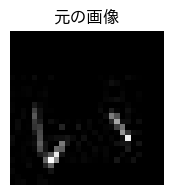

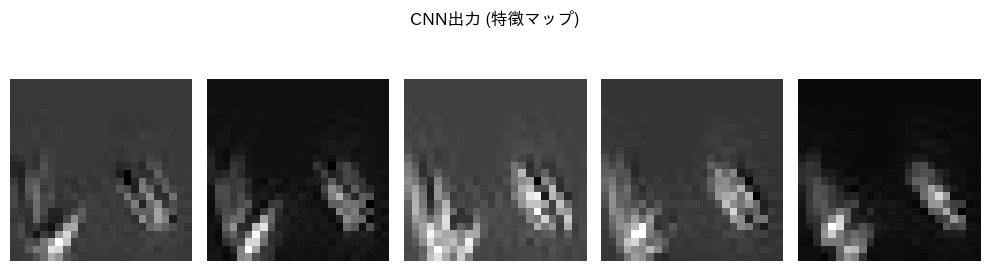

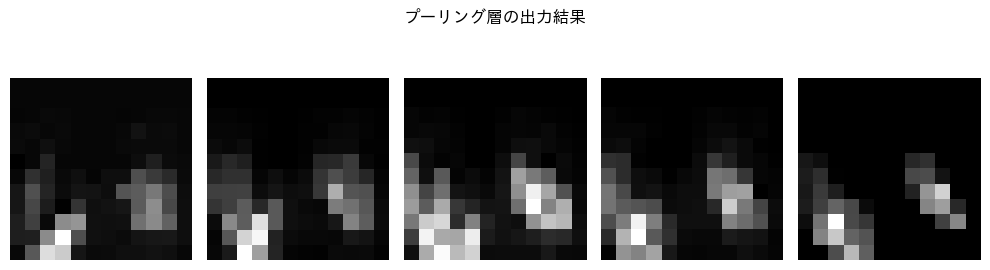

In [17]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# テスト用の一つの画像を選択
# あ：300, い：500　う：200 え：600　お:100
sample_image = x[500].unsqueeze(0)  # バッチ次元を追加 (1, 1, 28, 28)

# モデルを評価モードに
model.eval()

# 推論実行
with torch.no_grad():
    prediction, feature_map, act_feature_map = model(sample_image)
    
# 特徴マップのサイズは (1, c=1, h, w) 
# バッチとチャネル次元を削除して2D画像として表示
feature_map = feature_map.squeeze().cpu().numpy()  # 2D配列に変換
act_feature_map = act_feature_map.squeeze().cpu().numpy()

# 元の画像と特徴マップを並べて表示
plt.figure(figsize=(2,2))
plt.title('元の画像')
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.axis('off')
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(10, 3))
plt.suptitle('CNN出力 (特徴マップ)')
for i, ax in enumerate(axes):
    ax.imshow(feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(10,3))
plt.suptitle("プーリング層の出力結果")
for i, ax in enumerate(axes):
    ax.imshow(act_feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

### カーネルの可視化

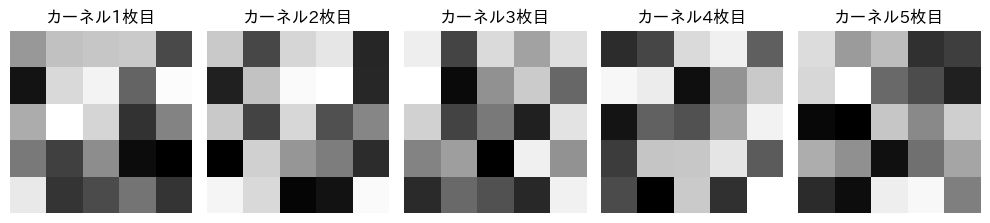

In [16]:
# カーネルの重みを取得
kernels = model.cnn1.weight.data.cpu().numpy()  # 形状は (1, 1, 5, 5)

fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(kernels[i].squeeze(), cmap='gray')
    ax.set_title(f'カーネル{i+1}枚目')
    ax.axis('off')
plt.tight_layout()
plt.show()